In [1]:
!git clone https://github.com/parhamzm/Beijing-Pollution-DataSet

Cloning into 'Beijing-Pollution-DataSet'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [2]:
!ls Beijing-Pollution-DataSet

pollution.csv  polution_dataSet.npy  README.md


In [0]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import random_split

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from numpy import array
from numpy import hstack

# **Data Pre Processing**

In [4]:
DATA_DIR = "Beijing-Pollution-DataSet/"
from pandas import read_csv
from datetime import datetime

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps=11, n_samples=12000, start_from=0):
	X, y = list(), list()
	for i in range(start_from, (start_from + n_samples)):
        # find the end of this pattern
		end_ix = i + n_steps
        # check if we are beyond the dataset
        # gather input and output parts of the pattern
		seq_x = sequences[i:end_ix, :]
		seq_y = sequences[end_ix, 0]
		y.append(seq_y)
		X.append(seq_x)
  
	return array(X), array(y)


# load dataset
DATA_DIR = "Beijing-Pollution-DataSet/"

data = np.load(DATA_DIR + 'polution_dataSet.npy')
scaled_data = data

# specify the number of lag hours
n_hours = 11
n_features = 8
# frame as supervised learning
# reframed = series_to_supervised(scaled_data, n_hours, 1)
# print("Reframed Shape: ", reframed.shape)

# # split into train and test sets
# values = reframed.values
# n_train_hours = 12000 #365 * 24
# train = values[:n_train_hours, :]

# test = values[n_train_hours:n_train_hours+3000, :]
# # split into input and outputs
# n_obs = n_hours * n_features
# train_X, train_y = train[:, :n_obs], train[:, -n_features]
# test_X, test_y = test[:, :n_obs], test[:, -n_features]
# print("Train X shape : => ", train_X.shape, len(train_X), ", Train y Shape :=> ", train_y.shape)
# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
# test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# convert dataset into input/output
n_timesteps = 11
dataset = data
print(data.shape)
train_X, train_y = split_sequences(sequences=dataset, n_steps=n_timesteps, n_samples=15000, start_from=0)
# train_y = train_y.reshape(len(train_y), 1)
test_X, test_y = split_sequences(sequences=dataset, n_steps=n_timesteps, n_samples=3000, start_from=15000)

(43799, 8)


In [5]:
test_loader_X = torch.utils.data.DataLoader(dataset=(train_X), batch_size=20, shuffle=False)
# train_X = torch.tensor(train_X, dtype=torch.float32)    
# train_y = torch.tensor(train_y, dtype=torch.float32)
print("Train X Shape :=> ", train_X.shape)
print("Train Y Shape :=> ", train_y.shape)
print("####################################")
print("Test X Shape :=> ", test_X.shape)
print("Test Y Shape :=> ", test_y.shape)

Train X Shape :=>  (15000, 11, 8)
Train Y Shape :=>  (15000,)
####################################
Test X Shape :=>  (3000, 11, 8)
Test Y Shape :=>  (3000,)


In [0]:
class LSTM(torch.nn.Module):
    def __init__(self, n_features=8, n_output=1, seq_length=11, n_hidden_layers=233, n_layers=1):
        super(LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length

        self.n_hidden = n_hidden_layers # number of hidden states
        self.n_layers = n_layers # number of LSTM layers (stacked)
        self.n_output = n_output

        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size, seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden * self.seq_len, self.n_output)


    def forward(self, x):
        hidden_state = torch.zeros(self.n_layers, x.size(0), self.n_hidden).requires_grad_()
        cell_state = torch.zeros(self.n_layers, x.size(0), self.n_hidden).requires_grad_()
        self.hidden = (hidden_state.detach(), cell_state.detach())

        batch_size, seq_len, _ = x.size()

        lstm_out, self.hidden = self.l_lstm(x, self.hidden)

        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size, -1)
        # print("X shape :=> ", x.shape)
        # out = self.l_linear(lstm_out[:, -1, :])
        # print("Out Shape :=> ", lstm_out[:, -1, :].shape)
        out = self.l_linear(x)
        return out

In [0]:
torch.manual_seed(13)
model = LSTM(n_features=8, n_output=1, seq_length=11, n_hidden_layers=233, n_layers=1)
criterion = nn.L1Loss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0003)

In [8]:
model = model #.to(device)
criterion = criterion #.to(device)
for p in model.parameters():
    print(p.numel())

7456
217156
932
932
2563
1


In [9]:
import time
start_time = time.time()

# train_X, train_y
epochs = 100
model.train()
batch_size = 200
running_loss_history = []
val_running_loss_history = []
for epoch in range(epochs):
    running_loss = 0.0
    val_running_loss = 0.0
    model.train()
    for b in range(0, len(train_X), batch_size):
        inpt = train_X[b:b+batch_size, :, :]
        target = train_y[b:b+batch_size]

        # print("Input Shape :=> ", inpt.shape)

        x_batch = torch.tensor(inpt, dtype=torch.float32)    
        y_batch = torch.tensor(target, dtype=torch.float32)

        output = model(x_batch) 
        loss = criterion(output.view(-1), y_batch)

        running_loss += loss.item()

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 

    else:
        
        with torch.no_grad(): # it will temprerorerly set all the required grad flags to be false
            model.eval()
            for b in range(0, len(test_X), batch_size):
                inpt = test_X[b:b+batch_size, :, :]
                target = test_y[b:b+batch_size]   

                x_batch_test = torch.tensor(inpt, dtype=torch.float32)
                y_batch_test = torch.tensor(target, dtype=torch.float32)

                # model.init_hidden(x_batch_test.size(0))

                output_test = model(x_batch_test) 
                loss_test = criterion(output_test.view(-1), y_batch_test)

                val_running_loss += loss_test.item()

    val_epoch_loss = val_running_loss / len(test_X)
    val_running_loss_history.append(val_epoch_loss)
    epoch_loss = running_loss / len(train_X)
    running_loss_history.append(epoch_loss)
    print('step : ' , epoch , ' Train loss : ' , epoch_loss, ', Valid Loss : => ', val_epoch_loss)
    print("***->>>-----------------------------------------------<<<-***")

total_time = time.time() - start_time
print("===========================================================")
print("*********************************************************")
print("The total Training Time is Equal with ==> : {0} Sec.".format(total_time))
print("*********************************************************")
print("===========================================================")

step :  0  Train loss :  0.00028904371956984203 , Valid Loss : =>  0.00032653038452068965
***->>>-----------------------------------------------<<<-***
step :  1  Train loss :  0.00021705336446563403 , Valid Loss : =>  0.0002565800646940867
***->>>-----------------------------------------------<<<-***
step :  2  Train loss :  0.00017943174354732036 , Valid Loss : =>  0.00021421559527516366
***->>>-----------------------------------------------<<<-***
step :  3  Train loss :  0.00015840888222058615 , Valid Loss : =>  0.00018751587346196174
***->>>-----------------------------------------------<<<-***
step :  4  Train loss :  0.0001462653884043296 , Valid Loss : =>  0.00017552017358442147
***->>>-----------------------------------------------<<<-***
step :  5  Train loss :  0.0001370898090923826 , Valid Loss : =>  0.0001632505562156439
***->>>-----------------------------------------------<<<-***
step :  6  Train loss :  0.00012965758262823026 , Valid Loss : =>  0.00014917956727246442
**

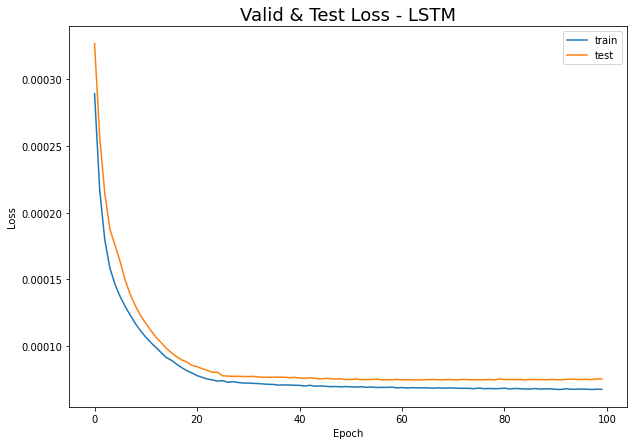

In [20]:
f, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.title("Valid & Test Loss - LSTM", fontsize=18)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(running_loss_history, label='train')
plt.plot(val_running_loss_history, label='test')
# pyplot.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
x, y = split_sequences(dataset, n_timesteps, n_samples=100, start_from=20500)

future = 100
window_size = 11
# preds = dataset[14989:15000, :].tolist()
# print(len(preds))
# print(preds)
model.eval()
x = torch.tensor(x, dtype=torch.float32)
# for i in range (future):
#     # seq = torch.FloatTensor(preds[-window_size:])
#     with torch.no_grad():
#         # seq = torch.tensor(seq, dtype=torch.float32).view(1, 11, 8)
#         # model.hidden = (torch.zeros(1, 1, model.hidden_size),
#         #                 torch.zeros(1, 1, model.hidden_size))
        
#         preds.append(model(seq))
res = model(x)
# print(preds[11:])

torch.Size([100, 1])


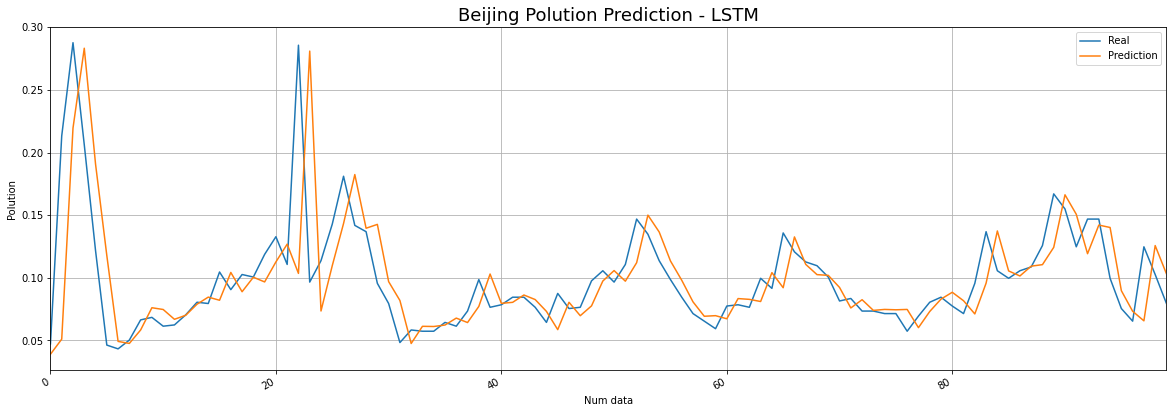

In [12]:
fig = plt.figure(figsize=(20, 7))
plt.title("Beijing Polution Prediction - LSTM", fontsize=18)
plt.ylabel('Polution')
plt.xlabel('Num data')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
fig.autofmt_xdate()

# plt.plot(data[15000:15100, 0])
plt.plot(y, label="Real")
# plt.plot(preds[12:])
print(res.shape)
plt.plot(res.detach().numpy(), label="Prediction")
plt.legend()
plt.show()

In [13]:
test_x, test_y = split_sequences(dataset, n_timesteps, n_samples=3000, start_from=18000)
model.eval()
test_x2 = torch.tensor(test_x, dtype=torch.float32)


test_running_loss = 0
with torch.no_grad(): # it will temprerorerly set all the required grad flags to be false
    model.eval()
    for b in range(0, len(test_x), batch_size):
        inpt = test_x[b:b+batch_size, :, :]
        target = test_y[b:b+batch_size]   

        x_batch_test = torch.tensor(inpt, dtype=torch.float32)
        y_batch_test = torch.tensor(target, dtype=torch.float32)

        # model.init_hidden(x_batch_test.size(0))

        output_test = model(x_batch_test)

        loss_test = criterion(output_test.view(-1), y_batch_test)

        test_running_loss += loss_test.item()

    test_epoch_loss = test_running_loss / len(test_x)

print("##########################################################")
print(">>>>---------------------------------------------------<<<<")
print(">>>>----------***************************--------------<<<<")
print("**** Test Loss :==>>> ", test_epoch_loss)
print(">>>>----------***************************--------------<<<<")
print(">>>>---------------------------------------------------<<<<")
print("##########################################################")

##########################################################
>>>>---------------------------------------------------<<<<
>>>>----------***************************--------------<<<<
**** Test Loss :==>>>  6.509193141634266e-05
>>>>----------***************************--------------<<<<
>>>>---------------------------------------------------<<<<
##########################################################


# **Predict Only 12 & 24 Times!**

In [0]:
# split a multivariate sequence into samples
def split_sequences12(sequences, n_steps, n_samples=12000, start_from=0):
    X, y = list(), list()
    j = 0
    for i in range(start_from, (start_from + n_samples)):
        # find the end of this pattern
        end_ix = j*12 + n_steps + start_from
        # check if we are beyond the dataset
        # gather input and output parts of the pattern
        j = j + 1
        seq_x = sequences[end_ix-11:end_ix, :]
        seq_y = sequences[end_ix, 0]
        y.append(seq_y)
        X.append(seq_x)
    print("End :=> ", end_ix)
    return array(X), array(y)

In [15]:
x, y = split_sequences12(sequences=dataset, n_steps=11, n_samples=100, start_from=20500)
x = torch.tensor(x, dtype=torch.float32)
x.shape

End :=>  21699


torch.Size([100, 11, 8])

In [0]:
model.eval()
res = model(x)

torch.Size([100, 1])


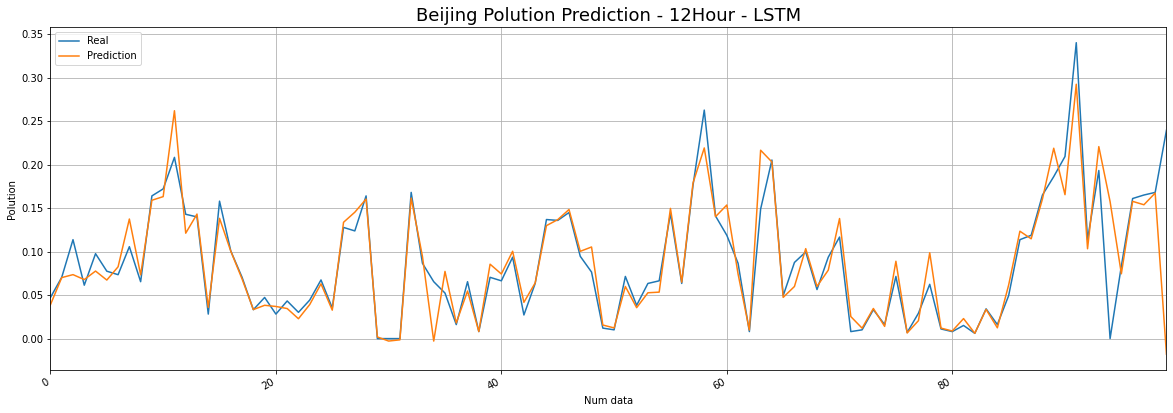

In [17]:
fig = plt.figure(figsize=(20, 7))
plt.title("Beijing Polution Prediction - 12Hour - LSTM", fontsize=18)
plt.ylabel('Polution')
plt.xlabel('Num data')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
fig.autofmt_xdate()

# plt.plot(data[15000:15100, 0])
plt.plot(y, label="Real")
# plt.plot(preds[12:])
print(res.shape)
plt.plot(res.detach().numpy(), label="Prediction")
plt.legend()
plt.show()

In [0]:
df_y = DataFrame(y)

df_y.columns = ['Real Values']
df_y['Predicted Values'] = res.detach().numpy()
# dataset.index.name = 'date'

In [19]:
pd.set_option("max_rows", None)
df_y.to_csv('Predict_every12Hour_LSTM_ADAM_MAE.csv')
df_y

,Real Values,Predicted Values
0,0.047284,0.038962
1,0.070423,0.070082
2,0.113682,0.073509
3,0.061368,0.067823
4,0.097586,0.077599
5,0.077465,0.067273
6,0.073441,0.082511
7,0.105634,0.137408
8,0.065392,0.073288
9,0.163984,0.158975
